## Importing all the required modules

In [3]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, Cropping2D, Dropout, Flatten, Dense, Lambda, MaxPooling2D
from keras import optimizers
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import csv
from sklearn.utils import shuffle


Using TensorFlow backend.
C:\Users\Barathi\Miniconda3\envs\carnd-term2\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


## Fetching the data from CSV file

In [4]:
samples = []
data_path = "../data/data/"
with open(data_path+'driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)
samples = samples[1:]          # Removing the header line

for sample in samples:
    for i in range(0,3):
        sample[i] = data_path+sample[i].strip()


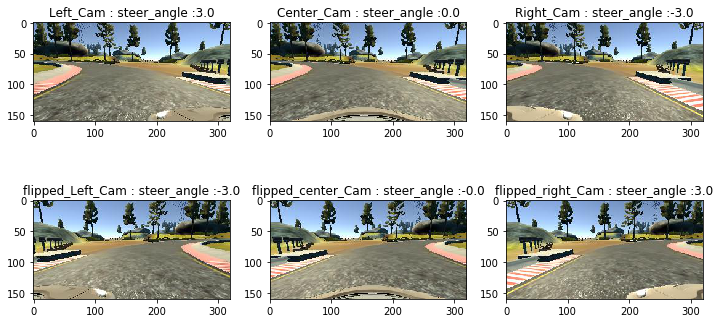

In [11]:
img_center = plt.imread(samples[13][0])
img_left = plt.imread(samples[13][1])
img_right = plt.imread(samples[13][2])
steering_angle = float(samples[13][3].strip())

f, axes = plt.subplots(2, 3, figsize=(12, 6))
axes[0][0].imshow(img_left)
axes[0][0].set_title("Left_Cam : steer_angle :"+str(steering_angle+3))
axes[0][1].imshow(img_center)
axes[0][1].set_title("Center_Cam : steer_angle :"+str(steering_angle))
axes[0][2].imshow(img_right)
axes[0][2].set_title("Right_Cam : steer_angle :"+str(steering_angle-3))
axes[1][0].imshow(np.fliplr(img_left))
axes[1][0].set_title("flipped_Left_Cam : steer_angle :"+str(-steering_angle-3))
axes[1][1].imshow(np.fliplr(img_center))
axes[1][1].set_title("flipped_center_Cam : steer_angle :"+str(-steering_angle))
axes[1][2].imshow(np.fliplr(img_right))
axes[1][2].set_title("flipped_right_Cam : steer_angle :"+str(-steering_angle+3))

In [3]:
def create_nvidia_model(input_shape):
    nvidia_model = Sequential()
    
    
    # As suggested in Nvidia's paper, converting the image to YUV spectrum :
    # http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf
    # nvidia_model.add(Lambda(yuv_conversion, input_shape=(160, 320, 3)))

    nvidia_model.add(Lambda(lambda x: (x-128)/128, input_shape=input_shape))

    nvidia_model.add(Cropping2D(((70, 25), (0, 0))))

    nvidia_model.add(Conv2D(24, (5, 5), activation="relu", strides=(2, 2)))
    #nvidia_model.add(Dropout(0.2))

    nvidia_model.add(Conv2D(36, (5, 5), activation="relu", strides=(2, 2)))
    #nvidia_model.add(Dropout(0.2))

    nvidia_model.add(Conv2D(48, (5, 5), activation="relu", strides=(2, 2)))
    nvidia_model.add(Dropout(0.1))

    nvidia_model.add(Conv2D(64, (3, 3), activation="relu"))
    nvidia_model.add(Dropout(0.1))

    nvidia_model.add(Conv2D(64, (3, 3), activation="relu"))
    nvidia_model.add(Dropout(0.1))

    nvidia_model.add(Flatten())

    nvidia_model.add(Dense(100, activation='relu'))
    nvidia_model.add(Dropout(0.3))

    nvidia_model.add(Dense(50, activation='relu'))
    nvidia_model.add(Dropout(0.3))

    nvidia_model.add(Dense(10, activation='relu'))
    nvidia_model.add(Dense(1))
    opt = optimizers.adam(lr=0.002)

    nvidia_model.compile(optimizer=opt, loss='mse')

    return nvidia_model


In [4]:
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

def generator(samples, batch_size=32, generator_name = "Generator", center_only=False, augment_images=True):
    
    def generator_function():
        num_samples = len(samples)
        
        # Loop forever so the generator never terminates
        while 1: 
            shuffle(samples)
            processed_samples = 0
            correction = 0.3

            for offset in (range(0, num_samples, batch_size)):
                processed_samples = processed_samples + batch_size
                batch_samples = samples[offset:offset+batch_size]
                images = []
                angles = []

                for batch_sample in batch_samples:

                    name = data_path+'/IMG/'+batch_sample[0].split('/')[-1]
                    center_image = cv2.imread(name)

                    # As the Image frames are processed by drive.py is in RGB colorspace
                    center_image = cv2.cvtColor(center_image,cv2.COLOR_BGR2RGB) 
                    center_angle = float(batch_sample[3])
                    images.append(center_image)
                    angles.append(center_angle)

                    # Augmentation of training images using flip
                    if augment_images == True:
                        center_image_flipped = np.fliplr(center_image)
                        center_angle_flipped = -center_angle
                        images.append(center_image_flipped)
                        angles.append(center_angle_flipped)

                    # Adding left and right camera images with correction
                    if center_only==False:
                        name = data_path+'/IMG/'+batch_sample[1].split('/')[-1]
                        left_image = cv2.imread(name)
                        left_image = cv2.cvtColor(left_image,cv2.COLOR_BGR2RGB) 
                        left_angle = float(batch_sample[3]) + correction
                        images.append(left_image)
                        angles.append(left_angle)
                        if augment_images == True:
                            left_image_flipped = np.fliplr(left_image)
                            left_angle_flipped = -left_angle
                            images.append(left_image_flipped)
                            angles.append(left_angle_flipped)

                        name = data_path+'/IMG/'+batch_sample[2].split('/')[-1]
                        right_image = cv2.imread(name)
                        right_image = cv2.cvtColor(right_image,cv2.COLOR_BGR2RGB) 
                        right_angle = float(batch_sample[3]) - correction
                        images.append(right_image)
                        angles.append(right_angle)
                        if augment_images == True:
                            right_image_flipped = np.fliplr(right_image)
                            right_angle_flipped = -right_angle
                            images.append(right_image_flipped)
                            angles.append(right_angle_flipped)

                X_array = np.array(images)
                y_array = np.array(angles)
                yield shuffle(X_array, y_array)

            # To check whether all training samples are processed for a single epoch
            # processed_samples shouldn't exceed num_samples
            processed_samples = processed_samples-(processed_samples % num_samples)
            print("{} : {} samples of {} has been processed".format(generator_name, processed_samples,
                                                                    num_samples))
            print("Augmentation : {}, Considered image from only center camera : {}".format(augment_images,
                                                                                        center_only))

    return generator_function
            
            
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32, generator_name="Training set  ")
validation_generator = generator(validation_samples, batch_size=32, generator_name="Validation set",
                                center_only=True, augment_images=False)


# Refer : https://stackoverflow.com/questions/41651628/negative-dimension-size-caused-by-subtracting-3-from-1-for-conv2d

model = create_nvidia_model((160,320,3))
batch_size = 32
history_object = model.fit_generator(train_generator(), steps_per_epoch = len(train_samples) / batch_size,
                                     validation_data=validation_generator(),
                                     validation_steps=len(validation_samples) / batch_size, epochs=10, verbose = 2)

Epoch 1/10
Training set   : 6428 samples of 6428 has been processed
Augmentation : True, Considered image from only center camera : False
Validation set : 1608 samples of 1608 has been processed
Augmentation : False, Considered image from only center camera : True
 - 149s - loss: 0.0366 - val_loss: 0.0230
Epoch 2/10
Training set   : 6428 samples of 6428 has been processed
Augmentation : True, Considered image from only center camera : False
Validation set : 1608 samples of 1608 has been processed
Augmentation : False, Considered image from only center camera : True
 - 145s - loss: 0.0295 - val_loss: 0.0232
Epoch 3/10
Training set   : 6428 samples of 6428 has been processed
Augmentation : True, Considered image from only center camera : False
Validation set : 1608 samples of 1608 has been processed
Augmentation : False, Considered image from only center camera : True
 - 145s - loss: 0.0282 - val_loss: 0.0211
Epoch 4/10
Training set   : 6428 samples of 6428 has been processed
Augmentatio

dict_keys(['loss', 'val_loss'])
training loss   =  0.0222613557434
validation loss =  0.0188819876228


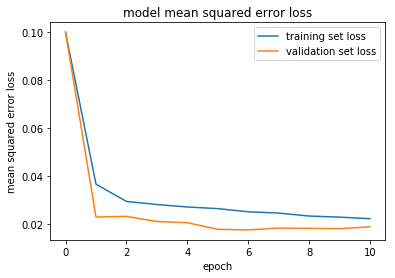

In [5]:
print(history_object.history.keys())
print("training loss   = ",(history_object.history['loss'])[-1])
print("validation loss = ",(history_object.history['val_loss'])[-1])

### plot the training and validation loss for each epoch
plt.plot([0.1]+history_object.history['loss'])
plt.plot([0.1]+history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set loss', 'validation set loss'], loc='upper right')
plt.show()


In [6]:
model.save("model.h5")

In [13]:
from IPython.display import HTML

HTML("""
<video width="320" height="160" controls>
  <source src="{0}">
</video>
""".format('../video.mp4'))